<a href="https://colab.research.google.com/github/TJConnellyContingentMacro/northwestern/blob/master/TS8_Part2_GDP_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
!pip install arch

In [0]:
!pip install pmdarima

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arch
from arch import arch_model
#from arch import ConstantMean, GARCH, Normal

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

pd.set_option('display.float_format', lambda x: '%.3f' % x)

import seaborn as sn


In [0]:
import statsmodels.stats as sm_stat
def tsdiag(y, figsize = (14, 8), title = "", lags = 30):
    tmp_data = pd.Series(y)
    #tmp_data.index += 1
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # Plot Ljung-Box and Box-Pierce statistic p-values:
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[1], 'bo', label = "Ljung-Box values")
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[3], 'go', label = "Box-Pierce values")
    plt.xticks(np.arange(1,  len(tmp_acor[0]) + 1, 1.0))
    plt.axhline(y = 0.05, color = "red", label = "5% critical value")
    plt.title("$Time\ Series\ " + title + "$")
    plt.legend()
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

This function is for plotting and quick EDA - prefer to use tsdisplay

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        #scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        pp_ax.hist(y)
        pp_ax.set_title('Histogram')
        plt.tight_layout()
    return 

In [0]:
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

In [0]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Ingest

Data Ingest From:
https://raw.githubusercontent.com/TJConnellyContingentMacro/TimeSeries/




In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/TJConnellyContingentMacro/TimeSeries/master/gdpdata.csv')

In [0]:
df['day'] = 30
df.tail()

,Unnamed: 0,year,mon,uk,ca,us,day
121,122,2010,4,328836,1320294,13058500,30
122,123,2010,7,330860,1328350,13139600,30
123,124,2010,10,329189,1338481,13216100,30
124,125,2011,1,330724,1350078,13227900,30
125,126,2011,4,331263,1348342,13271800,30


In [0]:
df.rename(columns={'mon':'Month'}, inplace = True)


In [0]:

df['Date'] = pd.to_datetime(df[['year','Month','day']].astype(str))
df.set_index(df['Date'], inplace = True)
df = df[['uk', 'ca', 'us']]


In [0]:

pd.concat([df.head(), df.tail()])
#df.columns

,uk,ca,us
Date,,,
1980-01-30,172436,624794,5908500
1980-04-30,169359,623433,5787400
1980-07-30,169038,623215,5776600
1980-10-30,167180,630215,5883500
1981-01-30,166052,645957,6005700
2010-04-30,328836,1320294,13058500
2010-07-30,330860,1328350,13139600
2010-10-30,329189,1338481,13216100
2011-01-30,330724,1350078,13227900


#**Exploratory Data Analysis**

Use EDA to justify a log transformation and a ﬁrst diﬀerence transformation, zit, of
each time series for i = 1, 2 hbﬁn and hbfrbn, respectively.


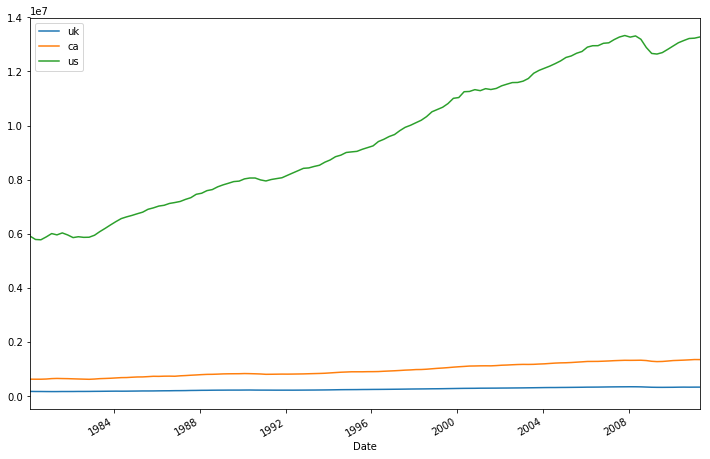

In [0]:
df.plot(figsize = (12, 8))

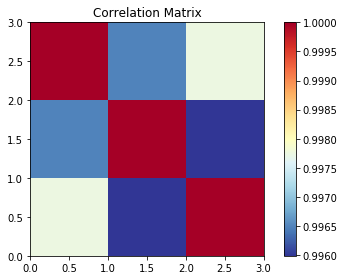

In [0]:
import statsmodels.graphics.api as smg
corr_matrix = np.corrcoef(df.T)
smg.plot_corr(corr_matrix)
plt.show()

## Stationarity Of First Series


### No Transformations

In [0]:
adf_test(df['uk'],title='UK GDP')
print ('\n')
adf_test(df['ca'],title='Canada GDP')
print ('\n')
adf_test(df['us'],title='USA GDP')

Augmented Dickey-Fuller Test: UK GDP
ADF test statistic      -0.878
p-value                  0.795
# lags used              1.000
# observations         124.000
critical value (1%)     -3.484
critical value (5%)     -2.885
critical value (10%)    -2.579
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: Canada GDP
ADF test statistic      -0.105
p-value                  0.949
# lags used              1.000
# observations         124.000
critical value (1%)     -3.484
critical value (5%)     -2.885
critical value (10%)    -2.579
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: USA GDP
ADF test statistic      -0.359
p-value                  0.917
# lags used              3.000
# observations         122.000
critical value (1%)     -3.485
critical value (5%)     -2.886
critical value (10%)

**Transformation is necessary as all series have unit roots and non-stationarity, according to ADF Tests.  We also see this in the plots below.**

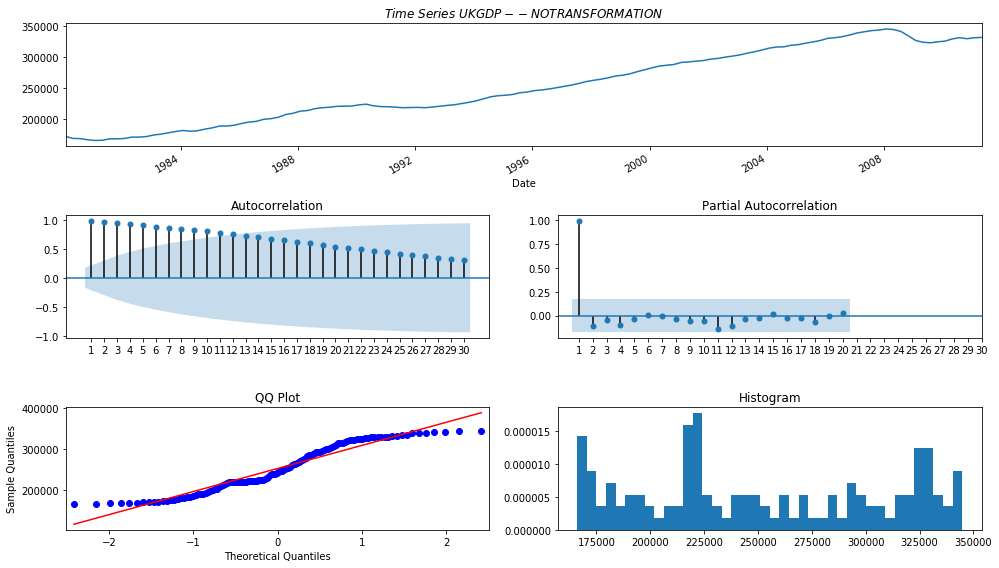

In [0]:
tsdisplay(df['uk'], lags=30, title = 'UK GDP -- NO TRANSFORMATION')

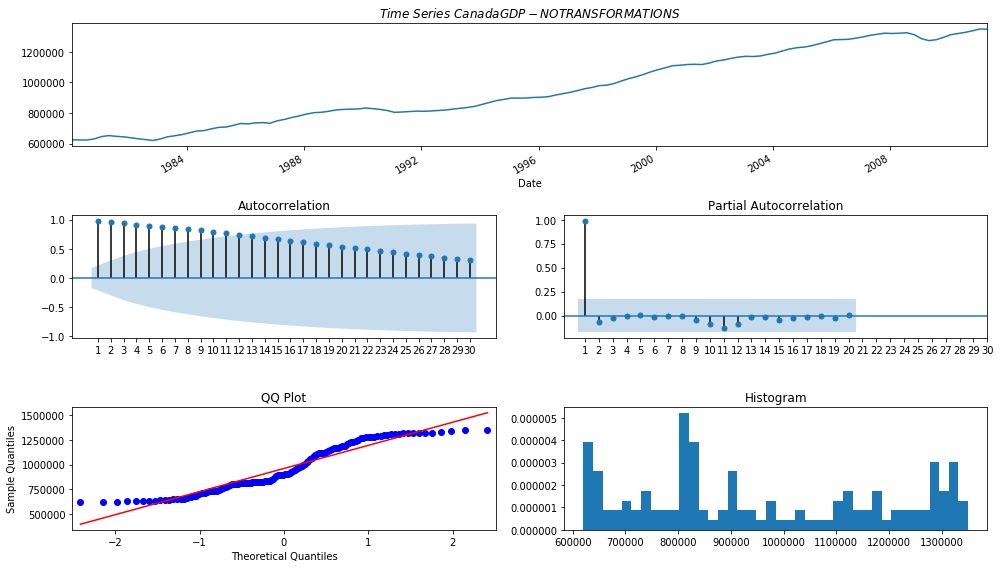

In [0]:
tsdisplay(df['ca'], lags=30, title = 'Canada GDP - NO TRANSFORMATIONS')

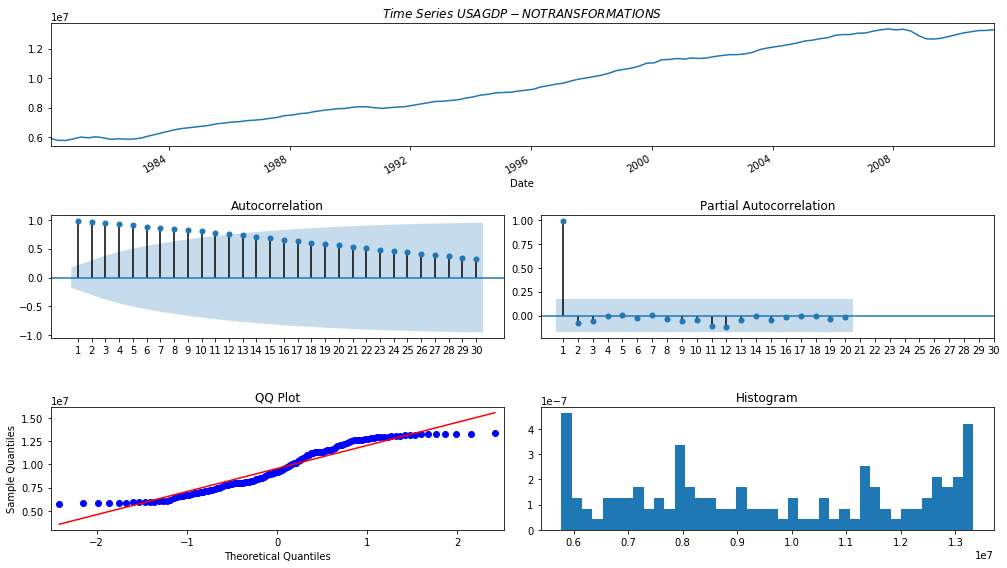

In [0]:
tsdisplay(df['us'], lags=30, title = 'USA GDP - NO TRANSFORMATIONS')

### Log Data and Take First Diff

In [0]:
df = np.log(df)
df = df.diff()
df = df.dropna()

We now run the ADF test again and see that there are no unit roots and data is stationary, at least by this test.

In [0]:
adf_test(df['uk'],title='UK GDP')
print ('\n')
adf_test(df['ca'],title='Canada GDP')
print ('\n')
adf_test(df['us'],title='USA GDP')

Augmented Dickey-Fuller Test: UK GDP
ADF test statistic      -6.434
p-value                  0.000
# lags used              0.000
# observations         124.000
critical value (1%)     -3.484
critical value (5%)     -2.885
critical value (10%)    -2.579
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: Canada GDP
ADF test statistic      -4.938
p-value                  0.000
# lags used              3.000
# observations         121.000
critical value (1%)     -3.486
critical value (5%)     -2.886
critical value (10%)    -2.580
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: USA GDP
ADF test statistic      -4.584
p-value                  0.000
# lags used              2.000
# observations         122.000
critical value (1%)     -3.485
critical value (5%)     -2.886
critical value (10%)    -2.580
Strong 

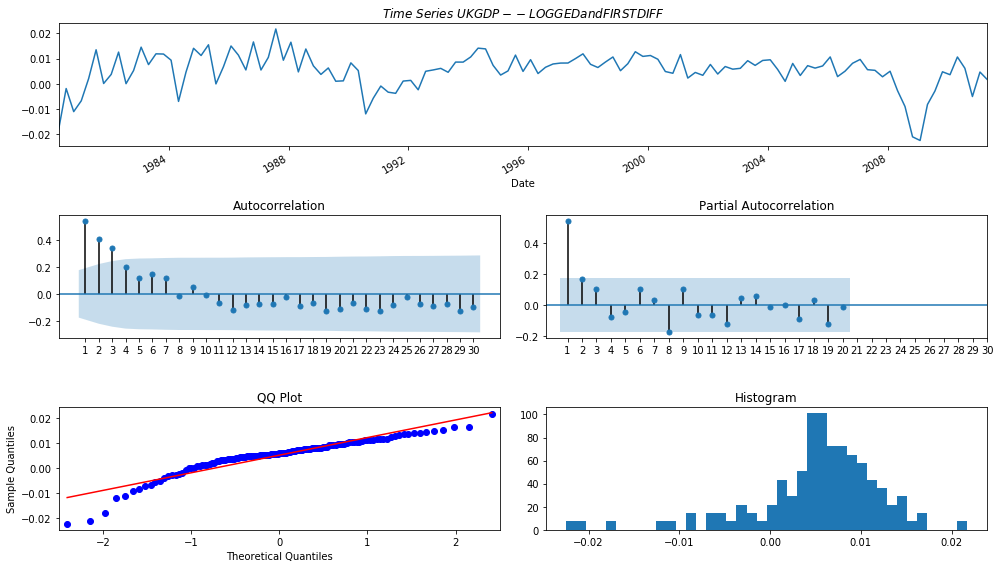

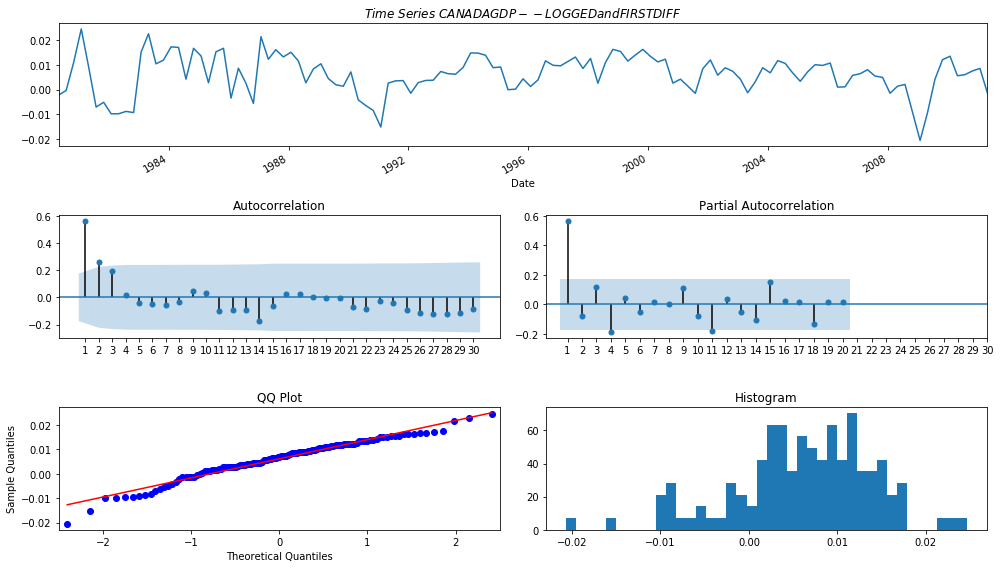

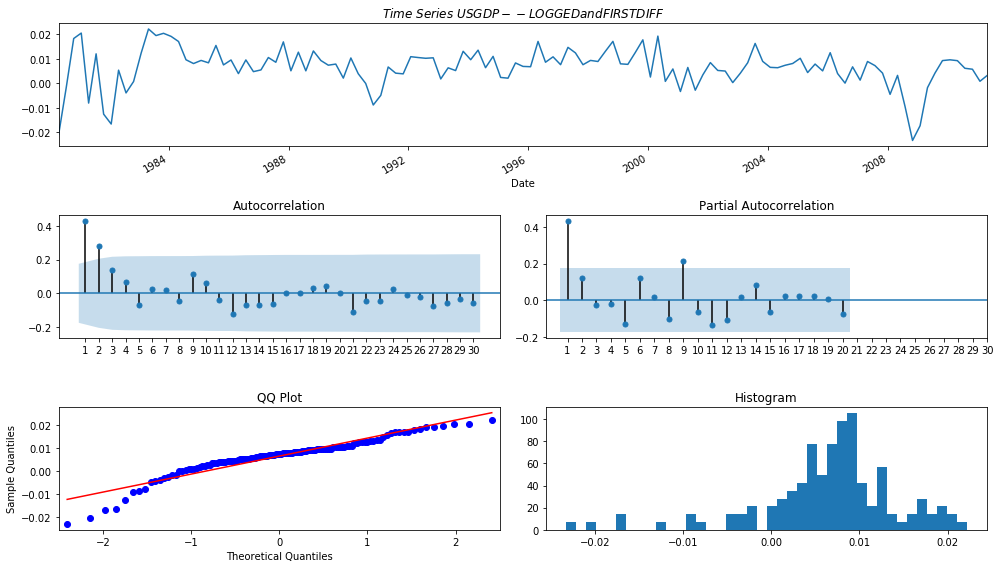

In [0]:
tsdisplay(df['uk'], lags=30, title = 'UK GDP -- LOGGED and FIRST DIFF')
tsdisplay(df['ca'], lags=30, title = 'CANADA GDP -- LOGGED and FIRST DIFF')
tsdisplay(df['us'], lags=30, title = 'US GDP -- LOGGED and FIRST DIFF')

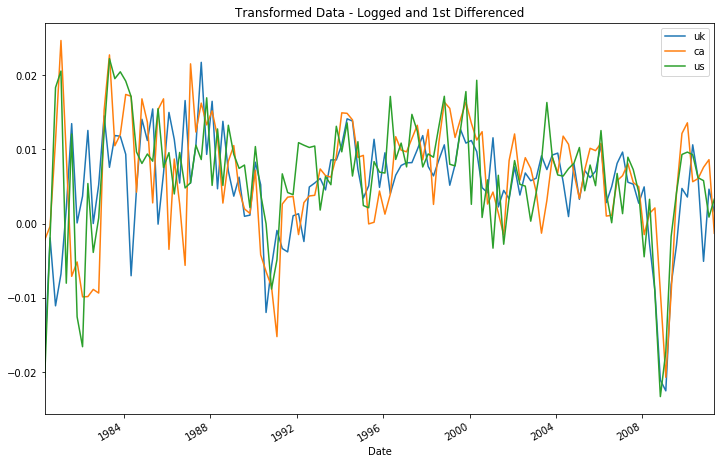

In [0]:
df.plot(figsize = (12,8), title = 'Transformed Data - Logged and 1st Differenced')

# Modeling & Analysis

### Cross Correlation Matrix

In [0]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df


In [0]:

df_new = df_derived_by_shift(df, 6,)
df_new = df_new.dropna()

df_new = df_new.corr()
df_new

,uk,ca,us,uk_1,uk_2,uk_3,uk_4,uk_5,uk_6,ca_1,ca_2,ca_3,ca_4,ca_5,ca_6,us_1,us_2,us_3,us_4,us_5,us_6
uk,1.000,0.503,0.542,0.552,0.404,0.370,0.226,0.167,0.160,0.458,0.403,0.143,0.188,0.114,0.066,0.475,0.342,0.321,0.070,0.152,0.132
ca,0.503,1.000,0.673,0.564,0.356,0.209,0.204,0.138,0.153,0.593,0.342,0.237,0.013,-0.056,-0.049,0.643,0.441,0.290,0.101,-0.040,0.038
us,0.542,0.673,1.000,0.534,0.234,0.226,0.166,0.112,0.147,0.493,0.281,0.109,-0.098,-0.077,-0.121,0.522,0.424,0.193,0.021,-0.061,0.030
uk_1,0.552,0.564,0.534,1.000,0.542,0.373,0.335,0.218,0.125,0.474,0.462,0.416,0.148,0.178,0.108,0.544,0.442,0.353,0.331,0.060,0.112
uk_2,0.404,0.356,0.234,0.542,1.000,0.546,0.375,0.340,0.223,0.565,0.472,0.440,0.411,0.151,0.183,0.529,0.544,0.427,0.342,0.335,0.073
uk_3,0.370,0.209,0.226,0.373,0.546,1.000,0.570,0.400,0.372,0.366,0.561,0.425,0.427,0.421,0.180,0.214,0.540,0.503,0.396,0.361,0.377
uk_4,0.226,0.204,0.166,0.335,0.375,0.570,1.000,0.576,0.440,0.238,0.348,0.485,0.401,0.432,0.431,0.205,0.247,0.480,0.454,0.407,0.405
uk_5,0.167,0.138,0.112,0.218,0.340,0.400,0.576,1.000,0.580,0.224,0.232,0.316,0.478,0.407,0.435,0.162,0.224,0.227,0.461,0.459,0.415
uk_6,0.160,0.153,0.147,0.125,0.223,0.372,0.440,0.580,1.000,0.176,0.203,0.152,0.284,0.477,0.418,0.085,0.205,0.160,0.172,0.470,0.511
ca_1,0.458,0.593,0.493,0.474,0.565,0.366,0.238,0.224,0.176,1.000,0.584,0.299,0.225,0.024,-0.033,0.652,0.651,0.403,0.262,0.118,0.014


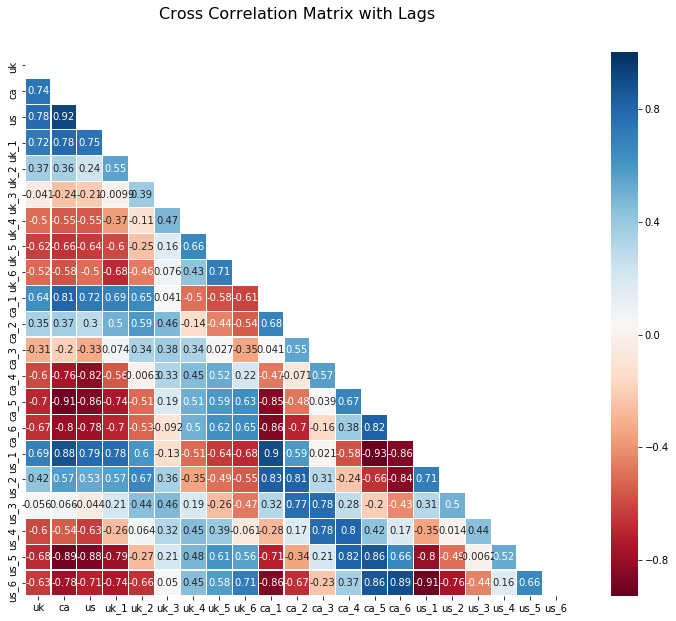

In [0]:

colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'Cross Correlation Matrix with Lags', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sn.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## VAR Model Order Selection

In [0]:
for i in [1,2,3,4,5,6,7]:
    model = VAR(df)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()


Order = 1
AIC:  -31.041306854470143
BIC:  -30.768376380379333

Order = 2
AIC:  -31.079817194030902
BIC:  -30.599688157747806

Order = 3
AIC:  -31.156611635499004
BIC:  -30.467098263843287

Order = 4
AIC:  -31.32404692608401
BIC:  -30.422924353536295

Order = 5
AIC:  -31.32406325951447
BIC:  -30.209066562401652

Order = 6
AIC:  -31.29536811670393
BIC:  -29.96419131748244

Order = 7
AIC:  -31.290244881435108
BIC:  -29.74053992198821



VAR 5 model has lowest combined scores



In [0]:
model.endog_names

['uk', 'ca', 'us']

In [0]:
results = model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Aug, 2019
Time:                     03:49:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -30.4229
Nobs:                     121.000    HQIC:                  -30.9581
Log likelihood:           1419.03    FPE:                2.49588e-14
AIC:                     -31.3240    Det(Omega_mle):     1.83766e-14
--------------------------------------------------------------------
Results for equation uk
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.001480         0.000748            1.978           0.048
L1.uk         0.515685         0.095298            5.411           0.000
L1.ca         0.071863         0.094459            0.761           0.447
L1.us         0.063904

In [0]:
results.test_whiteness(nlags = 10, signif = 0.05, adjusted = False).summary()

Test statistic,Critical value,p-value,df
51.55,72.15,0.570,54


**Portmanteau Test**

### Model Results

In [0]:
adf_test(results.resid['hbfin'],title='Residuals of VAR for Foreign Holders')

KeyError: ignored

In [0]:
lag_order = results.k_ar
lag_order
z = results.forecast(y=df.values[-lag_order:], steps=8)
z

In [0]:
df.tail()

In [0]:
idx = pd.date_range('05/30/2011', periods=8, freq='Q')
df_forecast = pd.DataFrame(z, index=idx, columns=['uk2d','ca2d','us2d'])


### Inverting the Transformation

In [0]:
nobs = 8
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['ukForecast'] = (df['uk'].iloc[-nobs-1]-df['uk'].iloc[-nobs-2]) + df_forecast['uk2d'].cumsum()
df_forecast['ukForecast'] = (df_forecast['ukForecast'])
#df_forecast['ukForecast'] = np.exp(df_forecast['ukForecast'])
# Now build the forecast values from the first difference set
#df_forecast['ukForecast'] = df['uk'].iloc[-nobs-1] + df_forecast['uk1d'].cumsum()

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['ca1d'] = (df['ca'].iloc[-nobs-1]-df['ca'].iloc[-nobs-2]) + df_forecast['ca2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['caForecast'] = df['ca'].iloc[-nobs-1] + df_forecast['ca1d'].cumsum()

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['us1d'] = (df['us'].iloc[-nobs-1]-df['us'].iloc[-nobs-2]) + df_forecast['us2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['usForecast'] = df['us'].iloc[-nobs-1] + df_forecast['us1d'].cumsum()

In [0]:
df_forecast

,uk2d,ca2d,us2d,uk1d,ukForecast,ca1d,caForecast,us1d,usForecast
2011-06-30,0.002,-0.001,0.001,0.017,0.017,0.010,0.001,0.016,0.014
2011-09-30,0.001,0.002,0.002,0.017,0.017,0.012,0.013,0.018,0.032
2011-12-31,0.005,0.002,0.003,0.022,0.022,0.014,0.027,0.020,0.052
2012-03-31,0.004,0.004,0.006,0.026,0.026,0.018,0.045,0.026,0.079
2012-06-30,0.004,0.005,0.006,0.030,0.030,0.023,0.068,0.032,0.111
2012-09-30,0.005,0.005,0.006,0.035,0.035,0.028,0.096,0.038,0.150
2012-12-31,0.005,0.006,0.007,0.040,0.040,0.034,0.131,0.045,0.195
2013-03-31,0.005,0.006,0.007,0.045,0.045,0.041,0.171,0.052,0.247


## Plot Results

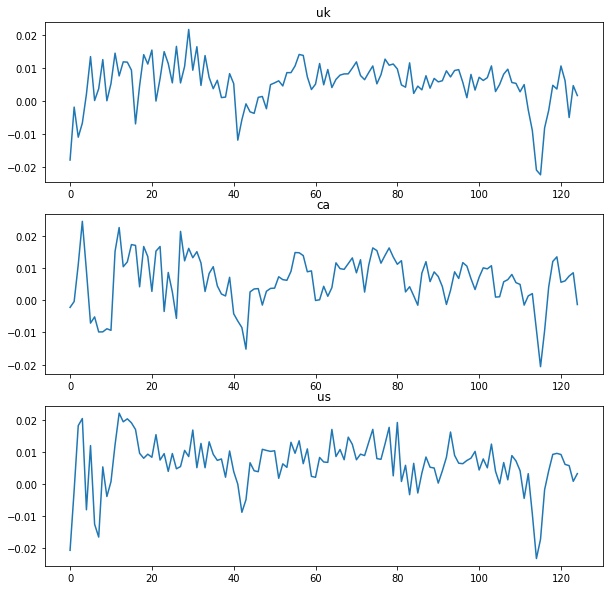

In [0]:
results.plot();

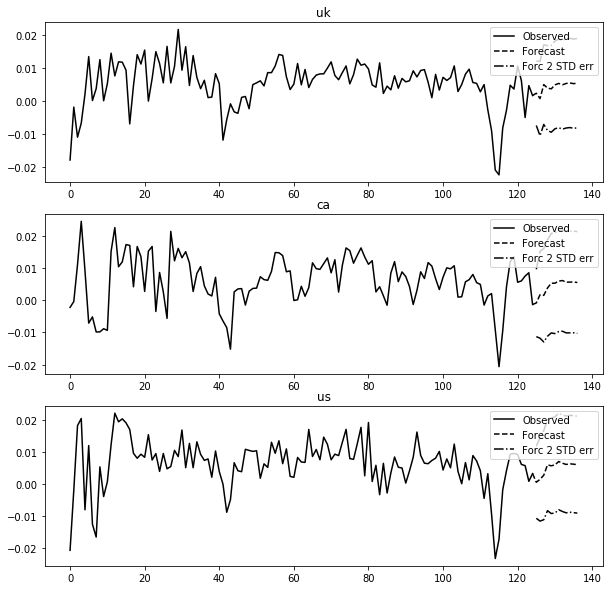

In [0]:
results.plot_forecast(12);

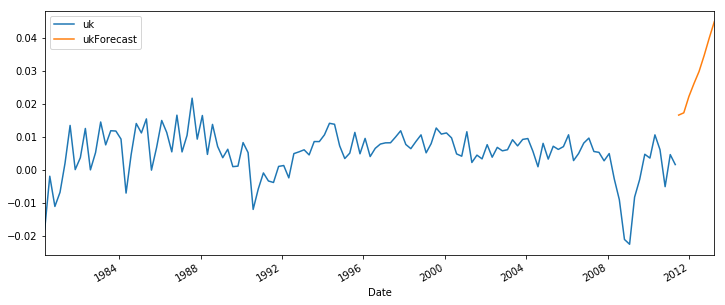

In [0]:
df['uk'].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['ukForecast'].plot(legend=True);

In [0]:
df['ca'].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['caForecast'].plot(legend=True);

In [0]:
df['us'].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['usForecast'].plot(legend=True);

In [0]:
from statsmodels.tsa.ar_model import AR,ARResults
modelM = AR(df['uk'])
AR5fit1 = modelM.fit(maxlag=5,method='mle')
print(f'Lag: {AR5fit1.k_ar}')
print(f'Coefficients:\n{AR5fit1.params}')